This notebook aims to create a `warp_matrices` file which is an affine transformation that can align the captures of the Dual-MX camera system. This `warp_matrices` file will be applied to all the flights

1. Find a capture where there are sufficient features in the scene
2. Make sure that the height of the capture > 35 m AGL


For best alignment results it's good to select a capture which has features which visible in all bands.  Man-made objects such as cars, roads, and buildings tend to work very well, while captures of only repeating crop rows tend to work poorly.  Remember, once a good transformation has been found for flight, it can be generally be applied across all of the images.

It's also good to use an image for alignment which is taken near the same level above ground as the rest of the flights. Above approximately 35m AGL, the alignement will be consistent. However, if images taken closer to the ground are used, such as panel images, the same alignment transformation will not work for the flight data.  

In [135]:
import importlib
import micasense.imageset
import micasense.capture
importlib.reload(micasense.imageset)
importlib.reload(micasense.capture)
import micasense.imageset as imageset
import micasense.capture as capture
import cv2
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils
import os, glob
import json
import tqdm
import pickle #This library will maintain the format as well
import radiometric_calib_utils
import mutils
from osgeo import gdal,osr
importlib.reload(radiometric_calib_utils)
importlib.reload(mutils)
import radiometric_calib_utils as rcu
import mutils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import algorithms.flight_attributes
importlib.reload(algorithms.flight_attributes)
import algorithms.flight_attributes as flight_attributes
import PIL.Image as Image
import extract_spectral as espect
import exiftool
import datetime
from mapboxgl.utils import df_to_geojson
from math import ceil

In [75]:
panel_fp = rcu.load_panel_fp(r"saved_data\panel_fp.json")
panel_albedo = mutils.load_pickle(r"saved_data\panel_albedo.ob")
center_wavelengths = mutils.load_pickle(r"saved_data\center_wavelengths_by_band.ob")
dls_panel_irr = mutils.load_pickle(r"saved_data\dls_panel_irr.ob")
dls_panel_irr_calibration = mutils.load_pickle(r"saved_data\dls_panel_irr_calibration.ob")

In [76]:
dir_fp = list(panel_fp.keys())[0]
cap_fp = panel_fp[dir_fp][0]
print(dir_fp)
print(cap_fp)
cap = capture.Capture.from_filelist(cap_fp)
panel_radiance = cap.panel_radiance()
panel_radiance_to_irradiance = lambda radiance,albedo: radiance*np.pi/albedo
panel_irradiance = [panel_radiance_to_irradiance(radiance,albedo) for radiance, albedo in zip(panel_radiance,panel_albedo)] #panel_radiance*np.pi/panel_albedo
print(panel_radiance)
print(panel_irradiance)

F:\surveys_10band\10thSur24Aug\F1\RawImg
['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_1.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_2.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_3.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_4.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_5.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_6.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_7.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_8.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_9.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_10.tif']
[0.14419940967335684, 0.14471271888042647, 0.12094172591079055, 0.06896841919866718, 0.0929759757107048, 0.15087091514665077, 0.1612072629085932, 0.1277203362299739, 0.1114749870194063, 0.1025448013702902]
[0.9415761103285069, 0.9468795081555529, 0.7934240877207821, 0.45438546360628734, 0.6106870676172149, 0.9843989

## Plot reflectance without wrap homography but corrected for lens distortion

['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_1.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_2.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_3.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_4.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_5.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_6.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_7.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_8.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_9.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0004_10.tif']
(960, 1280)


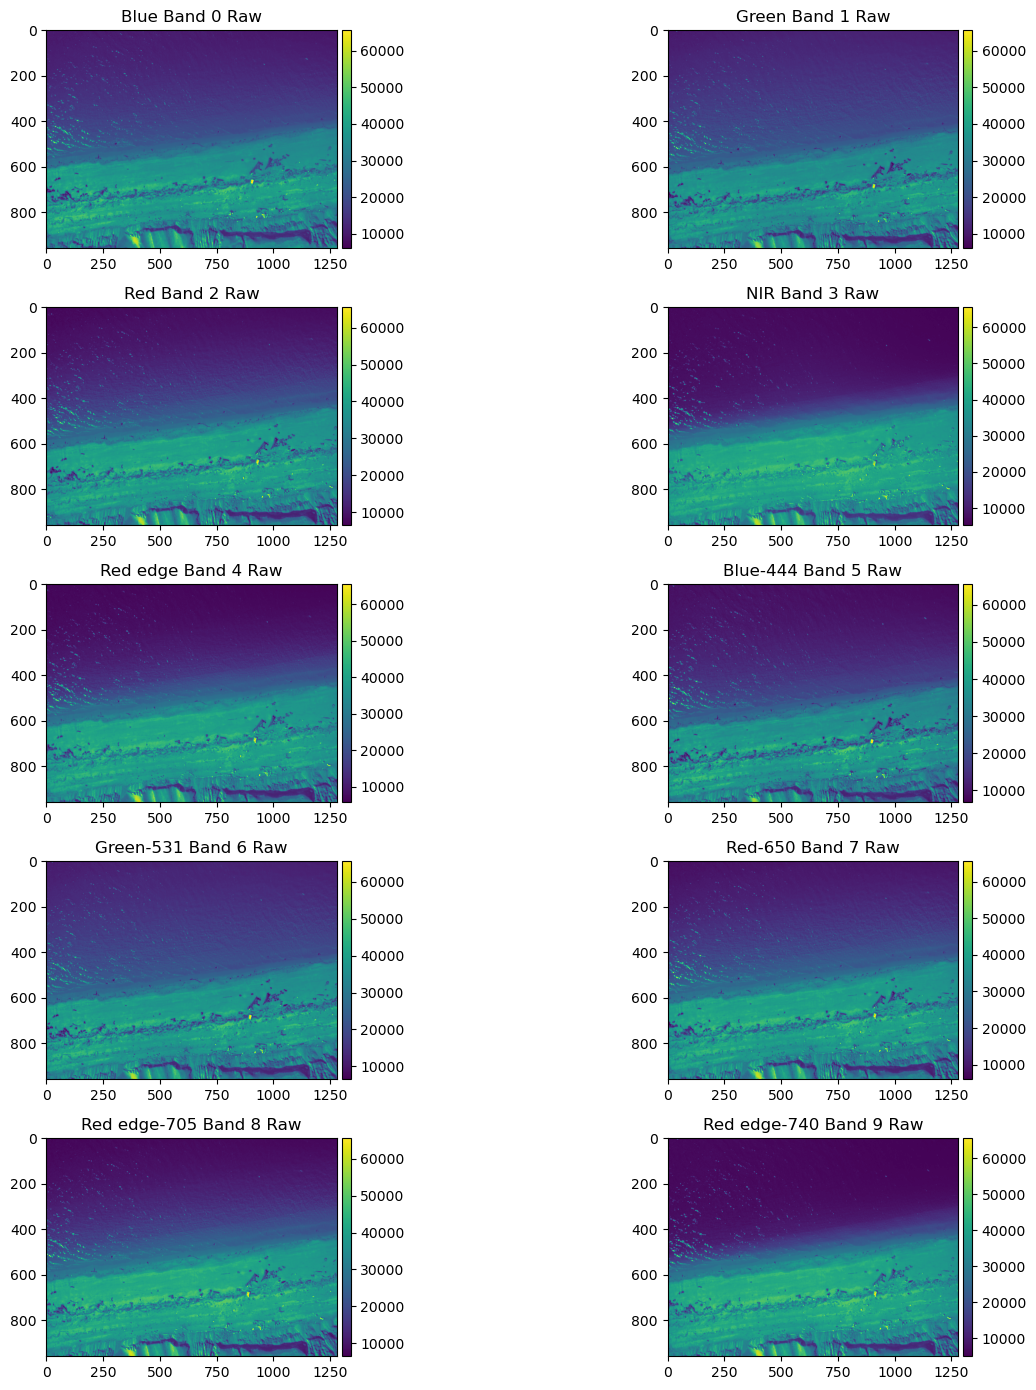

In [160]:
image_names = glob.glob(os.path.join(dir_fp,'IMG_0004_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)
# cap.plot_undistorted_reflectance(panel_irradiance) #undistorted_reflectance
img_shape = np.asarray(Image.open(image_names[0])).shape
print(img_shape)
cap.plot_raw()

# Check height of images

In [78]:
imagePath = r"F:\surveys_10band\1stSur6Apr\F1\RawImg"
imgset = imageset.ImageSet.from_directory(imagePath)
data, columns = imgset.as_nested_lists()
df = pd.DataFrame.from_records(data, index='timestamp', columns=columns)
df.head()

Loading ImageSet from: F:\surveys_10band\1stSur6Apr\F1\RawImg


latitude   longitude  altitude  \
timestamp                                                          
2022-04-06 03:14:37.372322+00:00  1.231912  103.630518    19.356   
2022-04-06 03:14:53.909274+00:00  1.231916  103.630518    19.297   
2022-04-06 03:25:09.599656+00:00  1.231914  103.630542    29.698   
2022-04-06 03:25:13.142936+00:00  1.231817  103.630522    36.184   
2022-04-06 03:25:14.995771+00:00  1.231747  103.630508    39.688   

                                            capture_id   dls-yaw  dls-pitch  \
timestamp                                                                     
2022-04-06 03:14:37.372322+00:00  DKycxS4lBNEBIgMv7EMJ  2.770871  -0.053952   
2022-04-06 03:14:53.909274+00:00  5jF5NqJwx9jzq2YHKlkE  2.769937  -0.126348   
2022-04-06 03:25:09.599656+00:00  Ap1yoOOF2gVo6wFw4rgW -3.096810  -0.248460   
2022-04-06 03:25:13.142936+00:00  Gc6eGH03htsNc081f9P8 -3.139642  -0.166312   
2022-04-06 03:25:14.995771+00:00  V7qXct9cNLM4WkjaDzzM -3.133579  -0.173759   

                                  dls-roll   irr-475   irr-560   irr-668  \
timestamp                                                                  
2022-04-06 03:14:37.372322+00:00  0.009055  1.732023  1.599768  1.368782   
2022-04-06 03:14:53.909274+00:00  0.006448  1.813087  1.675498  1.431167   
2022-04-06 03:25:09.599656+00:00  0.097935  1.596519  1.472876  1.255682   
2022-04-06 03:25:13.142936+00:00  0.107307  1.541424  1.422055  1.213235   
2022-04-06 03:25:14.995771+00:00  0.101554  1.519193  1.401495  1.196080   

                                   irr-842   irr-717   irr-444   irr-531  \
timestamp                                                                  
2022-04-06 03:14:37.372322+00:00  0.853344  1.054424  1.533242  1.637993   
2022-04-06 03:14:53.909274+00:00  0.893403  1.102981  1.607329  1.715373   
2022-04-06 03:25:09.599656+00:00  0.780899  0.962106  1.414741  1.508238   
2022-04-06 03:25:13.142936+00:00  0.753947  0.928812  1.365155  1.456089   
2022-04-06 03:25:14.995771+00:00  0.743011  0.915341  1.345082  1.435008   

                                   irr-650   irr-705   irr-740  
timestamp                                                       
2022-04-06 03:14:37.372322+00:00  1.351430  1.195858  1.099124  
2022-04-06 03:14:53.909274+00:00  1.414062  1.249963  1.148568  
2022-04-06 03:25:09.599656+00:00  1.238478  1.093779  1.006241  
2022-04-06 03:25:13.142936+00:00  1.196084  1.056527  0.972193  
2022-04-06 03:25:14.995771+00:00  1.178924  1.041485  0.958449

# Wrap homography with rig relatives

In [204]:
image_names = glob.glob(os.path.join(dir_fp,'IMG_0050_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)
warp_mode = cv2.MOTION_HOMOGRAPHY
warp_matrices = cap.get_warp_matrices()
img_type = "reflectance"
cropped_dimensions,edges = imageutils.find_crop_bounds(cap,warp_matrices)
im_aligned = imageutils.aligned_capture(cap, warp_matrices, warp_mode, cropped_dimensions, None, img_type=img_type)
print(im_aligned.shape)

['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_1.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_2.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_3.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_4.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_5.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_6.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_7.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_8.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_9.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_10.tif']
(919, 1226, 10)


# check if the same wrap_matrices can be used for another survey

['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_1.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_2.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_3.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_4.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_5.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_6.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_7.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_8.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_9.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_10.tif']


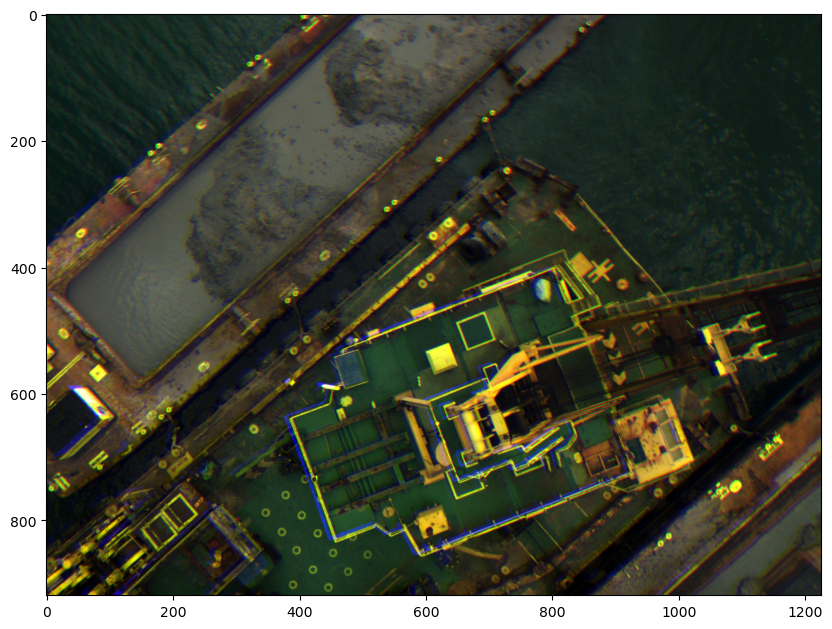

In [233]:
dir_fp = r"F:\surveys_10band\10thSur24Aug\F1\RawImg"
image_names = glob.glob(os.path.join(dir_fp,'IMG_0050_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)
warp_matrices_loaded = mutils.load_pickle("saved_data/warp_matrices_10band.ob")
cropped_dimensions = mutils.load_pickle("saved_data/cropped_dimensions.ob")
im_aligned = imageutils.aligned_capture(cap, warp_matrices_loaded, warp_mode, cropped_dimensions, None, img_type=img_type)
rgb_img = mutils.get_rgb(im_aligned)

['F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_1.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_2.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_3.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_4.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_5.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_6.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_7.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_8.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_9.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_10.tif']


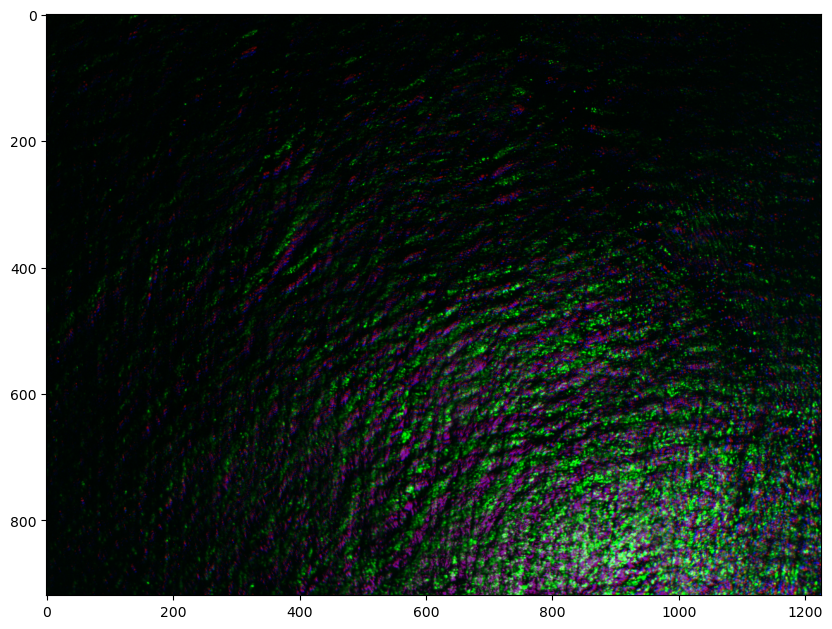

In [234]:
dir_fp = r"F:\surveys_10band\1stSur6Apr\F1\RawImg"
image_names = glob.glob(os.path.join(dir_fp,'IMG_0050_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)
warp_matrices_loaded = mutils.load_pickle("saved_data/warp_matrices_10band.ob")
cropped_dimensions = mutils.load_pickle("saved_data/cropped_dimensions.ob")
im_aligned = imageutils.aligned_capture(cap, warp_matrices_loaded, warp_mode, cropped_dimensions, None, img_type=img_type)
rgb_img = mutils.get_rgb(im_aligned)

As such, the same wrap homography matrix cannot be used for images taken from another flight. The misalginment is visible.

- `wrap_matrices` has to be used for individual flights

## Check if individual flight's `wrap_matrices` is needed for alignment

['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_1.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_2.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_3.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_4.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_5.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_6.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_7.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_8.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_9.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0050_10.tif']


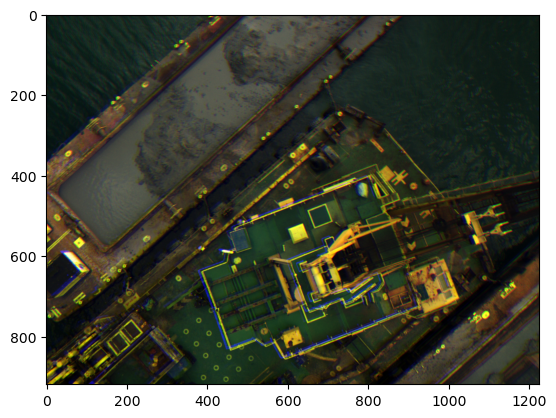

In [239]:
dir_fp = r"F:\surveys_10band\10thSur24Aug\F1\RawImg"
image_names = glob.glob(os.path.join(dir_fp,'IMG_0050_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)
cap = capture.Capture.from_filelist(image_names)
warp_matrices = cap.get_warp_matrices()
cropped_dimensions,edges = imageutils.find_crop_bounds(cap,warp_matrices)
img = mutils.aligned_capture(cap, warp_matrices, cropped_dimensions)

plt.figure()
plt.imshow(img)
plt.show()

['F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_1.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_2.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_3.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_4.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_5.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_6.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_7.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_8.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_9.tif', 'F:\\surveys_10band\\1stSur6Apr\\F1\\RawImg\\IMG_0050_10.tif']


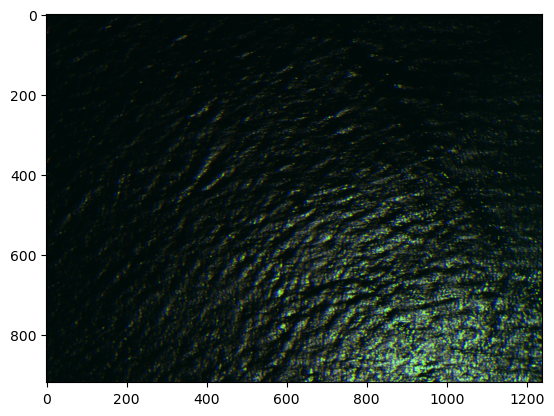

In [240]:
dir_fp = r"F:\surveys_10band\1stSur6Apr\F1\RawImg"
image_names = glob.glob(os.path.join(dir_fp,'IMG_0050_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)
warp_matrices = cap.get_warp_matrices()
cropped_dimensions,edges = imageutils.find_crop_bounds(cap,warp_matrices)
img = mutils.aligned_capture(cap, warp_matrices, cropped_dimensions)

plt.figure()
plt.imshow(img)
plt.show()

As such, the same wrap homography matrix cannot be used for images taken from another flight. The misalginment is visible.

- `wrap_matrices` has to be used for individual flights

# Plot bboxes

In [71]:
with open(r"saved_bboxes\1stSur6Apr_F1_RawImg_IMG_0003_1.txt", 'r') as fp:
    data = json.load(fp)
data

{'F:/surveys_10band/1stSur6Apr/F1/RawImg\\IMG_0003_1.tif': {'turbid_glint': None,
  'water_glint': None,
  'turbid': [[767, 104], [945, 285]],
  'water': [[1063, 80], [1137, 216]],
  'shore': [[880, 773], [945, 859]]}}

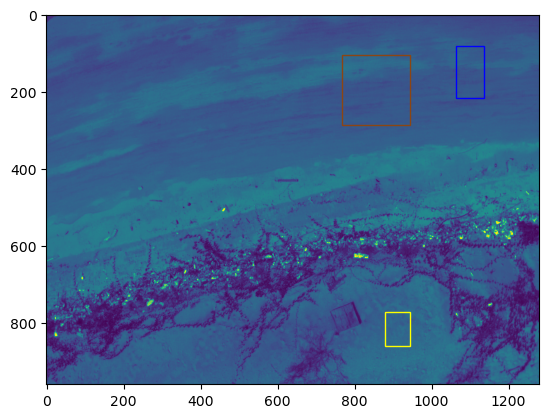

In [73]:
mutils.plot_bboxes(r"saved_bboxes\1stSur6Apr_F1_RawImg_IMG_0003_1.txt")

# Get yaw and flight angle

29.999999999999993


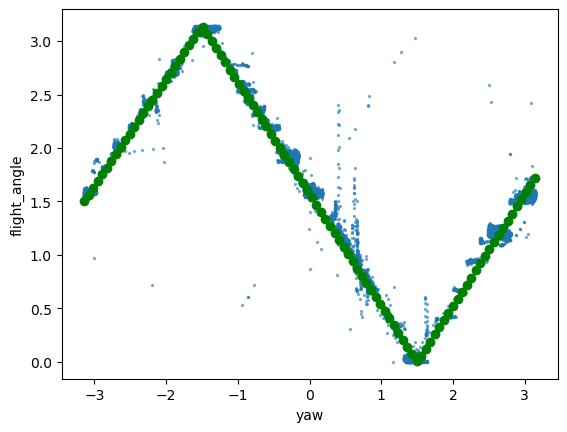

In [111]:
# #------EXTRACT FLIGHT ATTRIBUTES---------------
# for i,imagePath in enumerate(dir_list):
#     imgset = imageset.ImageSet.from_directory(imagePath)
#     data, columns = imgset.as_nested_lists()
#     df = pd.DataFrame.from_records(data, index='timestamp', columns=columns)
#     df['Index'] = list(range(len(df.index)))
#     dir_csv = os.path.join("flight_attributes",f'output{i}.csv')
#     dir_ob = os.path.join("flight_attributes",f'coord_yaw{i}.csv')
#     df.to_csv(dir_csv)
#     FA = flight_attributes.FlightAttributes(df)
#     FA.save_coord_yaw(fp=dir_ob) #FA.calculate_flight_angle()

# with open(os.path.join("flight_attributes",'flight_name.txt'), 'w') as f:
#     for i,imagePath in enumerate(dir_list):
#         f.write(f"{i}-{imagePath}\n")

def get_flight_angle_fn():
    """
    returns function and params
    """
    t0 = (-np.pi,1.5)
    t1 = (-1.5,np.pi)
    t2 = (1.5,0)
    t3 = (3,np.pi/2) #3,1.5

    k0 = (t1[1]-t0[1])/(t1[0]-t0[0])
    k1 = (t2[1]-t1[1])/(t2[0]-t1[0])
    k2 = (t3[1]-t2[1])/(t3[0]-t2[0])

    c0 = t0[1] - k0*t0[0]
    c1 = t1[1] - k1*t1[0]
    c2 = t2[1] - k2*t2[0]

    x0 = -1.5
    x1 = 1.5

    fn = lambda x: k0*x+c0 if x<x0 else (k1*x+c1 if (x<x1) else k2*x+c2)

    return fn, [k0,k1,k2,c0,c1,c2]

fn, params = get_flight_angle_fn()
plt.figure()
dir = os.path.join(os.getcwd(),"flight_attributes")
coord_yaw = [mutils.load_pickle(os.path.join(dir,fp)) for fp in os.listdir(dir) if fp.startswith('coord_yaw')]
coord_yaw = np.vstack(coord_yaw)

x = np.linspace(-np.pi,np.pi,100)
y = [fn(i) for i in x]
plt.scatter(coord_yaw[:,1],coord_yaw[:,0],s=2,alpha=0.5)
plt.plot(x,y,'o',c='green',linewidth=2)
plt.xlabel('yaw')
plt.ylabel('flight_angle')
plt.show()

# Get panel images

In [3]:
panelNames = None
useDLS = True

# imagePath = os.path.expanduser(os.path.join('~','Downloads','DualCam-Farm','farm_only'))
# panelNames = glob.glob(os.path.join(imagePath,'IMG_0002_*.tif'))

imagePath =  r"D:\EPMC_flight\pandanResTest\F2\RawImg"#r"D:\EPMC_flight\pandanResTest\F1\RawImg"
panelNames = glob.glob(os.path.join(imagePath,'IMG_0001_*.tif'))

outputPath = os.path.join(imagePath,'..','stacks')
thumbnailPath = os.path.join(outputPath, '..', 'thumbnails')

overwrite = False # Set to False to continue interrupted processing
generateThumbnails = True

# Allow this code to align both radiance and reflectance images; bu excluding
# a definition for panelNames above, radiance images will be used
# For panel images, efforts will be made to automatically extract the panel information
# but if the panel/firmware is before Altum 1.3.5, RedEdge 5.1.7 the panel reflectance
# will need to be set in the panel_reflectance_by_band variable.
# Note: radiance images will not be used to properly create NDVI/NDRE images below.
if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)
    warp_matrices = panelCap.get_warp_matrices()
else:
    panelCap = None
    warp_matrices = None
if panelCap is not None:
    if panelCap.panel_albedo() is not None:
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.65]*len(panelCap.images) #inexact, but quick
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
else:
    if useDLS:
        img_type='reflectance'
    else:
        img_type = "radiance"

## Batch import all images

In [137]:
imgset = imageset.ImageSet.from_directory(imagePath)

Loading ImageSet from: D:\EPMC_flight\pandanResTest\F2\RawImg


# band align all images

In [138]:
use_multi_process = True # set to False for single-process saving
overwrite_existing = False # skip existing files, set to True to overwrite

if not os.path.exists(outputPath):
    os.makedirs(outputPath)
if generateThumbnails and not os.path.exists(thumbnailPath):
    os.makedirs(thumbnailPath)

# If we didn't provide a panel above, irradiance set to None will cause DLS data to be used
try:
    irradiance = panel_irradiance+[0]
except NameError:
    irradiance = None

start_time = datetime.datetime.now()

# Save all captures in the imageset as aligned stacks
imgset.process_imageset(outputPath,
                     thumbnailPath,
                     warp_matrices,
                     irradiance = irradiance,
                     img_type='reflectance',
                     multiprocess=use_multi_process, 
                     overwrite=overwrite_existing)

end_time = datetime.datetime.now()

print("Saving time: {}".format(end_time-start_time))
print("Alignment+Saving rate: {:.2f} captures per second".format(float(len(imgset.captures))/float((end_time-start_time).total_seconds())))

Processing 200 Captures ...
Processing complete.
Saving time: 0:06:01.709471
Alignment+Saving rate: 0.55 captures per second


## Import saved band_aligned images

In [6]:
if os.path.exists(os.path.join(os.path.dirname(imagePath),'thumbnails')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'thumbnails')
    fp_list = [os.path.join(parent_dir,fp) for fp in sorted(os.listdir(parent_dir))]

else:
    fp_list = None

fp_list

['D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0000_1.tif.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0001_1.tif.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0002_1.tif.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0003_1.tif.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0004_1.tif.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0005_1.tif.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0006_1.tif.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0007_1.tif.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0008_1.tif.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0009_1.tif.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0010_1.tif.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0011_1.tif.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0012_1.tif.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0013_1.tif.jpg',
 'D:\\

## Import flight attributes df

In [79]:
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None

flight_attributes_df

timestamp  latitude   longitude  altitude  \
0    2022-12-12 03:57:49.580447+00:00  1.318993  103.736566    21.087   
1    2022-12-12 03:58:01.375906+00:00  1.318994  103.736560    20.668   
2    2022-12-12 03:58:06.763455+00:00  1.318993  103.736560    20.738   
3    2022-12-12 03:58:14.126010+00:00  1.318990  103.736558    20.748   
4    2022-12-12 04:05:13.319729+00:00  1.318973  103.736598    46.909   
..                                ...       ...         ...       ...   
195  2022-12-12 04:10:31.699520+00:00  1.318579  103.736206    50.559   
196  2022-12-12 04:10:33.991551+00:00  1.318580  103.736184    50.478   
197  2022-12-12 04:10:35.879041+00:00  1.318540  103.736175    50.352   
198  2022-12-12 04:10:37.496038+00:00  1.318494  103.736172    50.264   
199  2022-12-12 04:10:39.217919+00:00  1.318449  103.736188    50.212   

         image_name            capture_id   dls-yaw  dls-pitch  dls-roll  \
0    IMG_0000_1.tif  D1dqcVbYFpWLrqrhxp65  1.768448  -0.024328  0.037788   
1    IMG_0001_1.tif  LMTJeVzIycDVmOMUumUb  1.788463  -0.038676  0.020124   
2    IMG_0002_1.tif  StCrPCqY7hHXw8Hi0KFT  1.789900  -0.056701  0.007901   
3    IMG_0003_1.tif  1tfFGUbfuImG2Yocxjy6  1.777689  -0.093409 -0.037415   
4    IMG_0004_1.tif  1wg4rPxOLYgcuZEroYSA  1.831188  -0.017768 -0.018996   
..              ...                   ...       ...        ...       ...   
195  IMG_0195_1.tif  IS6TlJ7sRxxww7Eznvbd -0.254191  -0.009937 -0.045614   
196  IMG_0196_1.tif  EHWL7rV2OwMWXDmN2eXA -2.735515  -0.086592 -0.012487   
197  IMG_0197_1.tif  aYePc5Z9M5L2PcfWwxmp -2.771658  -0.086177 -0.047550   
198  IMG_0198_1.tif  8zpetseSkcuZwbd5y4GD  3.002090  -0.056153 -0.092705   
199  IMG_0199_1.tif  c5oM2zTNQo9z8qgYb2Rc  2.788039  -0.063716  0.022738   

      irr-475   irr-560   irr-668   irr-842   irr-717   irr-444   irr-531  \
0    0.526376  0.465279  0.392283  0.241601  0.302945  0.467606  0.483118   
1    0.527561  0.466350  0.393259  0.242179  0.303673  0.468595  0.484220   
2    0.528551  0.467233  0.394027  0.242640  0.304250  0.469456  0.485130   
3    0.528455  0.467123  0.394005  0.242590  0.304218  0.469292  0.485018   
4    0.576662  0.511715  0.430489  0.265818  0.331959  0.513646  0.530690   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.569590  0.504434  0.423628  0.261537  0.327051  0.507747  0.523478   
196  0.570460  0.505700  0.425010  0.262405  0.327994  0.508340  0.524625   
197  0.569283  0.504853  0.424308  0.262028  0.327462  0.507323  0.523689   
198  0.568230  0.504022  0.423668  0.261633  0.326930  0.506361  0.522789   
199  0.566952  0.502978  0.422781  0.261100  0.326208  0.505250  0.521677   

      irr-650   irr-705   irr-740  
0    0.385711  0.346326  0.320788  
1    0.386642  0.347184  0.321587  
2    0.387385  0.347855  0.322215  
3    0.387333  0.347848  0.322225  
4    0.423705  0.379125  0.350854  
..        ...       ...       ...  
195  0.417164  0.373395  0.345588  
196  0.418461  0.374500  0.346558  
197  0.417805  0.373846  0.345911  
198  0.417162  0.373247  0.345351  
199  0.416291  0.372423  0.344577  

[200 rows x 19 columns]

# Georeference

In [42]:
parent_dir = os.path.join(os.path.dirname(imagePath),'georeferenced_thumbnails')
if not os.path.exists(parent_dir):
    georeferenced_thumbnails_directory = os.path.join(os.path.dirname(imagePath),'georeferenced_thumbnails')
    os.mkdir(georeferenced_thumbnails_directory)

DEM_offset_height = 15
column_idx = [i for i,c in enumerate(flight_attributes_df.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
for i,rows in tqdm.tqdm(flight_attributes_df.iterrows()):
    if (i == 0) or (i == len(flight_attributes_df.index)-1):
        pass
    else:
        flight_att = rows[column_idx].tolist()
        flight_att[-2] = flight_att[-2] - DEM_offset_height
        image_name = rows['image_name']
        # estimate flight angle from 2 adjacent coordinates
        flight_att_diff = flight_attributes_df.iloc[[i-1,i+1],column_idx]
        flight_att_diff = flight_att_diff.iloc[:,:2].values
        flight_angle_coord = flight_attributes.get_flight_angle(flight_att_diff)
        flight_angle_coord = flight_angle_coord[0] + 90 if flight_angle_coord[0] > 90 else 90 - flight_angle_coord[0]
        # open image
        im = np.asarray(Image.open(fp_list[i])) if image_name in fp_list[i] else None
        if im is None:
            print("Image not found")
            break
        else:
            image_name = os.path.splitext(image_name)[0]
            image_fn = os.path.join(georeferenced_thumbnails_directory,image_name)
            GI = flight_attributes.GeotransformImage(im,*flight_att,angle=flight_angle_coord)
            GI.georegister(image_fn)

200it [08:57,  2.69s/it]


[1.3187524, 103.7365505, 36.23, -0.2697227577305283]
Flight angle from yaw: 106.183
Flight angle from coords: 112.228


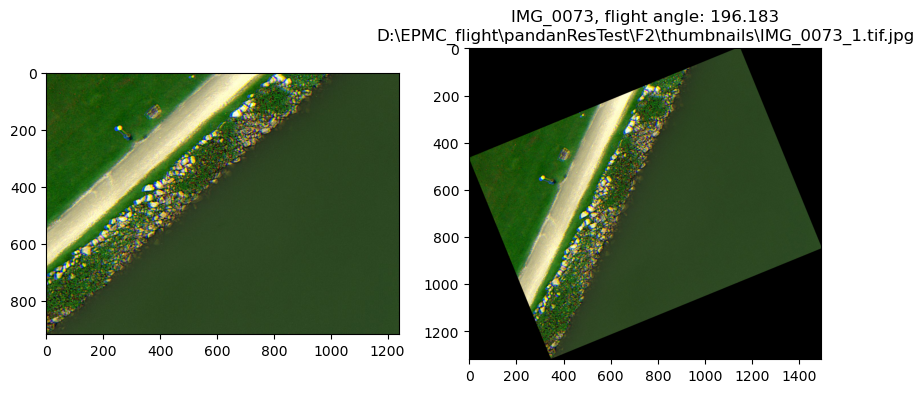

In [43]:
# import image and flight attributes
test_idx = 73
image_name = 'IMG_{}'.format(str(test_idx).zfill(4))
DEM_offset_height = 15
column_idx = [i for i,c in enumerate(flight_attributes_df.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
flight_att = flight_attributes_df.iloc[test_idx,column_idx].tolist()
flight_att[-2] = flight_att[-2] - DEM_offset_height
im = np.asarray(Image.open(fp_list[test_idx])) if image_name in fp_list[test_idx] else None
print(flight_att)

# estimate flight angle from yaw
fn,_ = flight_attributes.get_flight_angle_fn()
flight_angle = fn(flight_att[-1])/np.pi*180
print(f'Flight angle from yaw: {flight_angle:.3f}')
flight_angle = flight_angle + 90 if flight_angle > 90 else 90 - flight_angle

# estimate flight angle from coordinates
flight_att_diff = flight_attributes_df.iloc[[test_idx-1,test_idx+1],column_idx]
flight_att_diff = flight_att_diff.iloc[:,:2].values
flight_angle_coord = flight_attributes.get_flight_angle(flight_att_diff)
print(f'Flight angle from coords: {flight_angle_coord[0]:.3f}')
flight_angle_coord = flight_angle_coord[0] + 90 if flight_angle_coord[0] > 90 else 90 - flight_angle_coord[0]
# estimation of flight angle from coordinates is better
# geotransform image
GI = flight_attributes.GeotransformImage(im,*flight_att,angle=flight_angle_coord)
rot_im = GI.georegister()
# _ = GI.affine_transformation(plot=True)
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(im)
axes[1].imshow(np.fliplr(rot_im)) #need to fliplr cus QGIS
axes[1].set_title(f'{image_name}, flight angle: {flight_angle:.3f}\n{fp_list[test_idx]}')
plt.show()

# Interpolate Flight

200it [00:00, 1333.37it/s]
200it [00:00, 1547.47it/s]


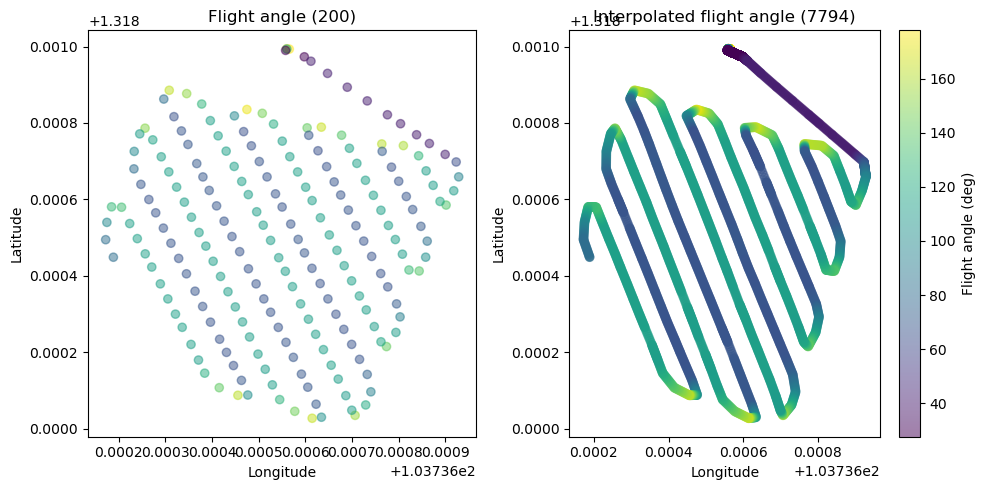

timestamp   timedelta  latitude   longitude  \
0    2022-12-12 03:57:49.580447+00:00    0.000000  1.318993  103.736566   
1    2022-12-12 03:57:49.680447+00:00    0.100000  1.318993  103.736566   
2    2022-12-12 03:57:49.780447+00:00    0.200000  1.318993  103.736566   
3    2022-12-12 03:57:49.880447+00:00    0.300000  1.318993  103.736565   
4    2022-12-12 03:57:49.980447+00:00    0.400000  1.318993  103.736565   
...                               ...         ...       ...         ...   
7789 2022-12-12 04:10:38.896038+00:00  769.315591  1.318457  103.736185   
7790 2022-12-12 04:10:38.996038+00:00  769.415591  1.318455  103.736186   
7791 2022-12-12 04:10:39.096038+00:00  769.515591  1.318452  103.736187   
7792 2022-12-12 04:10:39.196038+00:00  769.615591  1.318449  103.736188   
7793 2022-12-12 04:10:39.217919+00:00  769.615591  1.318449  103.736188   

       altitude  flight_angle      image_name            capture_id   dls-yaw  \
0     21.087000    177.878904  IMG_0000_1.tif  D1dqcVbYFpWLrqrhxp65  1.768448   
1     21.083448    177.878904  IMG_0000_1.tif  D1dqcVbYFpWLrqrhxp65  1.768448   
2     21.079896    177.878904  IMG_0000_1.tif  D1dqcVbYFpWLrqrhxp65  1.768448   
3     21.076343    177.878904  IMG_0000_1.tif  D1dqcVbYFpWLrqrhxp65  1.768448   
4     21.072791    177.878904  IMG_0000_1.tif  D1dqcVbYFpWLrqrhxp65  1.768448   
...         ...           ...             ...                   ...       ...   
7789  50.221721     81.334110  IMG_0198_1.tif  8zpetseSkcuZwbd5y4GD  3.002090   
7790  50.218701     81.334110  IMG_0198_1.tif  8zpetseSkcuZwbd5y4GD  3.002090   
7791  50.215681     81.334110  IMG_0198_1.tif  8zpetseSkcuZwbd5y4GD  3.002090   
7792  50.212661     81.334110  IMG_0198_1.tif  8zpetseSkcuZwbd5y4GD  3.002090   
7793  50.212000     81.334110  IMG_0199_1.tif  c5oM2zTNQo9z8qgYb2Rc  2.788039   

      dls-pitch  ...   irr-560   irr-668   irr-842   irr-717   irr-444  \
0     -0.024328  ...  0.465279  0.392283  0.241601  0.302945  0.467606   
1     -0.024328  ...  0.465279  0.392283  0.241601  0.302945  0.467606   
2     -0.024328  ...  0.465279  0.392283  0.241601  0.302945  0.467606   
3     -0.024328  ...  0.465279  0.392283  0.241601  0.302945  0.467606   
4     -0.024328  ...  0.465279  0.392283  0.241601  0.302945  0.467606   
...         ...  ...       ...       ...       ...       ...       ...   
7789  -0.056153  ...  0.504022  0.423668  0.261633  0.326930  0.506361   
7790  -0.056153  ...  0.504022  0.423668  0.261633  0.326930  0.506361   
7791  -0.056153  ...  0.504022  0.423668  0.261633  0.326930  0.506361   
7792  -0.056153  ...  0.504022  0.423668  0.261633  0.326930  0.506361   
7793  -0.063716  ...  0.502978  0.422781  0.261100  0.326208  0.505250   

       irr-531   irr-650   irr-705   irr-740  index  
0     0.483118  0.385711  0.346326  0.320788      0  
1     0.483118  0.385711  0.346326  0.320788      0  
2     0.483118  0.385711  0.346326  0.320788      0  
3     0.483118  0.385711  0.346326  0.320788      0  
4     0.483118  0.385711  0.346326  0.320788      0  
...        ...       ...       ...       ...    ...  
7789  0.522789  0.417162  0.373247  0.345351    198  
7790  0.522789  0.417162  0.373247  0.345351    198  
7791  0.522789  0.417162  0.373247  0.345351    198  
7792  0.522789  0.417162  0.373247  0.345351    198  
7793  0.521677  0.416291  0.372423  0.344577    199  

[7794 rows x 22 columns]

In [144]:
# import flight attributes df
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None
IF = flight_attributes.InterpolateFlight(flight_attributes_df)
df = IF.append_flight_angle()
df_interpolated = IF.interpolate_flight()
df_interpolated

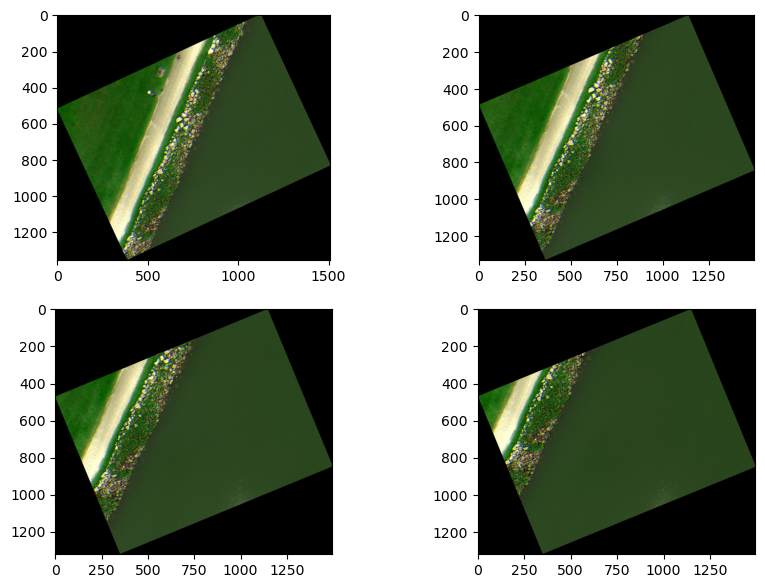

In [112]:
fig, axes = plt.subplots(2,2,figsize=(10,7))
for ax, im in zip(axes.flatten(), im_list.values()):
    ax.imshow(im)
plt.show()

In [139]:
if os.path.exists(os.path.join(os.path.dirname(imagePath),'thumbnails')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'thumbnails')
    fp_list = [os.path.join(parent_dir,fp) for fp in sorted(os.listdir(parent_dir))]

else:
    fp_list = None

fp_list

['D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0000_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0001_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0002_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0003_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0004_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0005_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0006_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0007_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0008_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0009_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0010_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0011_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0012_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0013_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0014_1.j

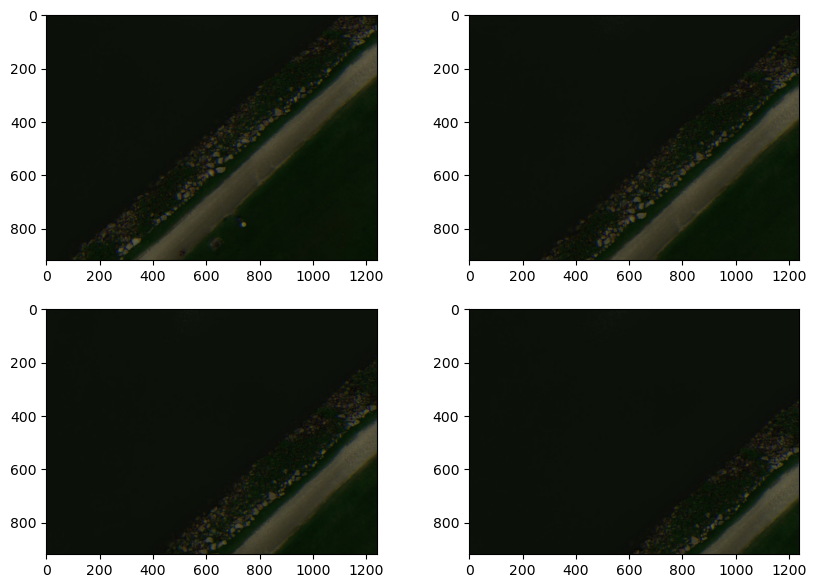

In [180]:
def import_georeference_im(fp):
    im = np.asarray(Image.open(fp))
    return im

fig, axes = plt.subplots(2,2,figsize=(10,7))
for ax, fp in zip(axes.flatten(), fp_list[78:82]):
    im = import_georeference_im(fp)
    ax.imshow(im)
plt.show()

In [182]:
class PlotGeoreference:
    def __init__(self, flight_attributes_df, fp_list, DEM_offset_height = 15):
        """ 
        :param flight_attributes_df (pd.DataFrame):  dataframe with flight angle
        :param fp_list (list of fp): filepath of the thumbnail
        :param geotransform_list (dict): 
            where key is the int index of the image
            where each value is a dict of keys:'lat','lon','lat_res','lon_res'
        :param im_list (dict): 
            where key is the int index of the image
            where each value is an image
        returns an np.ndarray
        """
        self.flight_attributes_df = flight_attributes_df
        # where keys are image index extracted from the image_name from fp_list
        self.fp_list = {int(os.path.splitext(os.path.split(fp)[-1])[0].split('_')[1]):fp for fp in fp_list}
        self.DEM_offset_height = DEM_offset_height

    def get_flight_attributes(self):
        """ 
        returns a dict, where keys are image_index that corresponds to image_name
        """
        column_idx = [i for i,c in enumerate(self.flight_attributes_df.columns.to_list()) if c in ['latitude','longitude','altitude','flight_angle']]

        # im_list = dict()
        geotransform_list = dict()

        for i,rows in self.flight_attributes_df.iterrows():
            flight_att = rows[column_idx].tolist()
            flight_att[-2] = flight_att[-2] - self.DEM_offset_height
            flight_angle_coord = rows['flight_angle']
            flight_angle_coord = flight_angle_coord + 90 if flight_angle_coord > 90 else 90 - flight_angle_coord

            GI = flight_attributes.GeotransformImage(None,*flight_att,angle=flight_angle_coord)
            lat_res, lon_res = GI.get_degrees_per_pixel()
            lat, lon = rows['latitude'], rows['longitude']
            img_idx = int(os.path.splitext(rows['image_name'])[0].split('_')[1])
            geotransform_list[img_idx] = {'lat':lat,'lon':lon,'lat_res':lat_res,'lon_res':lon_res,
                                    'flight_angle': flight_angle_coord, 'image_fp':self.fp_list[img_idx]}
        return geotransform_list

    def get_canvas(self):
        geotransform_list = self.get_flight_attributes()
        idx = 0
        lat_max = [idx,0]
        lat_min = [idx,180]
        lon_max = [idx,0]
        lon_min = [idx,180]
        pixel_res = 1
        for idx, gt in geotransform_list.items():
            if gt['lat'] > lat_max[1]:
                lat_max = [idx,gt['lat']]
            if gt['lat'] < lat_min[1]:
                lat_min = [idx,gt['lat']]
            if gt['lon'] > lon_max[1]:
                lon_max = [idx,gt['lon']]
            if gt['lon'] < lon_min[1]:
                lon_min = [idx, gt['lon']]
            if gt['lat_res'] < pixel_res:
                pixel_res = gt['lat_res']
            if gt['lon_res'] < pixel_res:
                pixel_res = gt['lon_res']
        
        self.pixel_res = pixel_res
        
        im_list = dict()
        for im_type, coord_type in zip(['upper_lat','lower_lat','left_lon','right_lon'],[lat_max,lat_min,lon_min,lon_max]):
            fp = self.fp_list[coord_type[0]]
            im = np.asarray(Image.open(fp))
            GI = flight_attributes.GeotransformImage(im,None,None,None,None,angle=geotransform_list[coord_type[0]]['flight_angle'])
            rot_im = GI.affine_transformation(plot=False)
            im_list[im_type] = rot_im

        upper_lat = lat_max[1] + ceil(im_list['upper_lat'].shape[0]/2)*pixel_res
        lower_lat = lat_min[1] - ceil(im_list['lower_lat'].shape[0]/2)*pixel_res
        left_lon = lon_min[1] - ceil(im_list['left_lon'].shape[1]/2)*pixel_res
        right_lon = lon_max[1] + ceil(im_list['right_lon'].shape[1]/2)*pixel_res

        self.upper_lat = upper_lat
        self.lower_lat = lower_lat
        self.left_lon = left_lon
        self.right_lon = right_lon

        nrow = ceil((upper_lat - lower_lat)/pixel_res)
        ncol = ceil((right_lon - left_lon)/pixel_res)
        im_display = np.zeros((nrow,ncol,3),dtype=np.uint8)
        print(f'shape of canvas{im_display.shape}')
        return im_display
    
    def get_row_col_index(self, lat, lon, lat_res, lon_res, rot_im):
        """ 
        :param lat (float): center coord of rot_im
        :param lon (float): center coord of rot_im
        :param rot_im (np.ndarray): rotated image
        returns the upp/low row and column index when provided center lat and lon values
        """
        nrow, ncol = rot_im.shape[0], rot_im.shape[1]
        row_idx = int((self.upper_lat - lat)/self.pixel_res)
        col_idx = int((lon - self.left_lon)/self.pixel_res)
        #row_idx and col_idx wrt to center coord
        upper_row_idx = row_idx - nrow//2
        lower_row_idx = upper_row_idx + nrow
        left_col_idx = col_idx - ncol//2
        right_col_idx = left_col_idx + ncol
        return upper_row_idx, lower_row_idx, left_col_idx, right_col_idx

    def plot_georeference(self):
        im_display = self.get_canvas()
        geotransform_list = self.get_flight_attributes()
        for i, rows in self.flight_attributes_df.iterrows():
            flight_angle_coord = rows['flight_angle']
            flight_angle_coord = flight_angle_coord + 90 if flight_angle_coord > 90 else 90 - flight_angle_coord

            img_idx = int(os.path.splitext(rows['image_name'])[0].split('_')[1])
            fp = self.fp_list[img_idx]
            im = np.asarray(Image.open(fp))
            GI = flight_attributes.GeotransformImage(im,None,None,None,None,angle=flight_angle_coord)
            rot_im = GI.affine_transformation(plot=False)
            rot_im = np.fliplr(np.flipud(rot_im))
            print(rot_im.shape)
            att = geotransform_list[img_idx]
            upper_row_idx, lower_row_idx, left_col_idx, right_col_idx = self.get_row_col_index(att['lat'],att['lon'],att['lat_res'],att['lon_res'],rot_im) #row/col idx wrt to center coord
            print(upper_row_idx, lower_row_idx, left_col_idx, right_col_idx)
            im_display[upper_row_idx:lower_row_idx,left_col_idx:right_col_idx,:] = rot_im
        
        plt.figure(figsize=(15,10))
        plt.imshow(im_display)
        plt.show()
        return


shape of canvas(1884, 1734, 3)
(1355, 1510, 3)
1 1356 0 1510
(1333, 1500, 3)
183 1516 81 1581
(1322, 1496, 3)
377 1699 161 1657
(1320, 1495, 3)
563 1883 238 1733


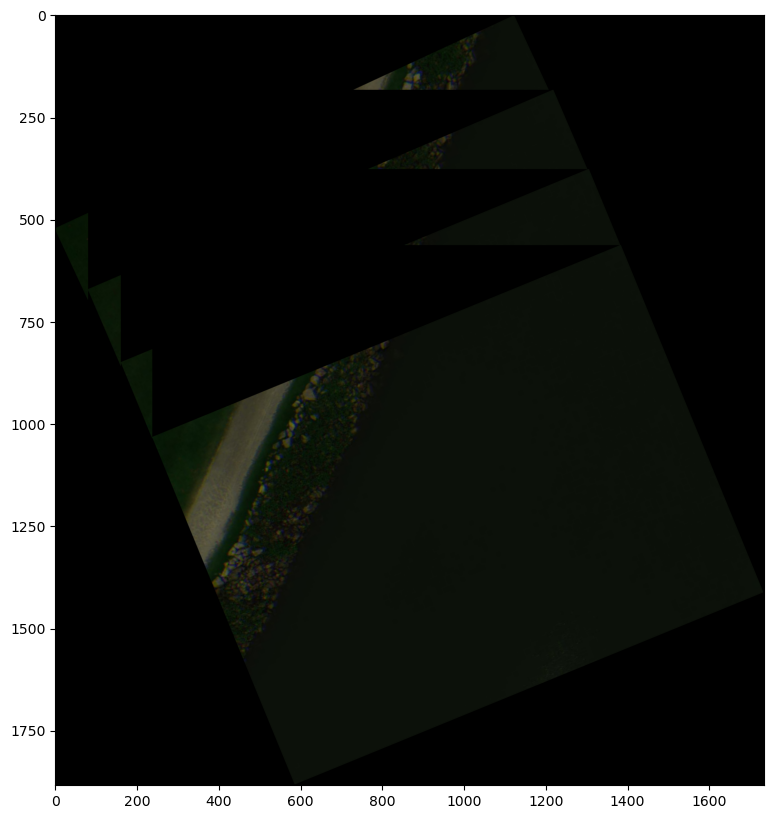

In [183]:
PG = PlotGeoreference(df.iloc[78:82,:],fp_list)
PG.plot_georeference() # add alpha_channel

In [179]:
fp_list[0]

'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0000_1.jpg'

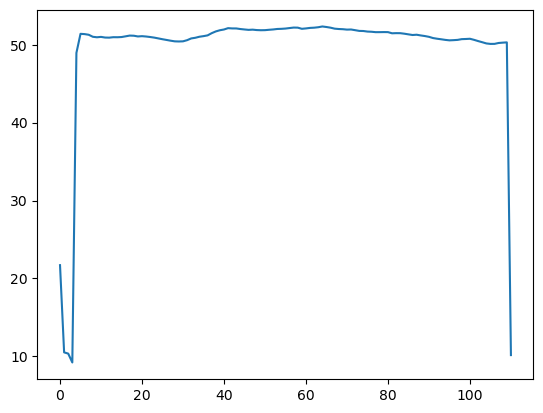

In [63]:
plt.figure()
plt.plot(list(range(len(flight_attributes_df.index))),flight_attributes_df['altitude'])
plt.show()

In [ ]:
import rasterio
from rasterio import features
from rasterio.io import MemoryFile
import math
import geopandas as gpd
import os 


w = 400
h = 400
zoom = 8
lat = -19.361500892883598
lng = -68.16004416617324
png_path = "path/to/png/mask"
output_path = "output/directory"


def getPointLatLng(x, y, lat, long,h,w):
    '''
    :param lat (float): coord of center pixel
    :param long (float): coord of center_pixel
    :param h (int): height of image (nrow)
    :param w (int): width of image (ncol)
    The function returns the geographical coordinates for a given pixel coordinates (x, y)
    '''
    parallelMultiplier = math.cos(lat * math.pi / 180)
    degreesPerPixelX = 360 / math.pow(2, zoom + 8)
    degreesPerPixelY = 360 / math.pow(2, zoom + 8) * parallelMultiplier
    pointLat = lat - degreesPerPixelY * ( y - h / 2)
    pointLng = long + degreesPerPixelX * ( x  - w / 2)

    return (pointLat, pointLng)


def getImgBounds(h,w):
    '''
    :param h (int): height of image (nrow)
    :param w (int): width of image (ncol)
    This function returns the coordinates of the image bounding box
    '''
    # Assuming that widht and heights are the same
    N, E = getPointLatLng(w, 0)
    S, W = getPointLatLng(0, h)
    N, W = getPointLatLng(0, 0)
    S, E = getPointLatLng(w, h)
    return [W, S, E, N]



def getGeoTiff(png_path, output_path):
    bounds = getImgBounds()
    dataset = rasterio.open(png_path)
    bands = [1]
    data = dataset.read(bands)
    transform = rasterio.transform.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], data.shape[1], data.shape[2])
    crs = rasterio.crs.CRS({"init": "epsg:4326"})   # 3857 Google Maps Projection    4326  World wide (3D)
    with rasterio.open(os.path.join(output_path, "salt_flat.tiff"), 'w', driver='GTiff',
                    width=data.shape[1], height=data.shape[2],
                    count=3, dtype=data.dtype, nodata=0,
                    transform=transform, crs=crs) as dst:
        dst.write(data, indexes=bands)


def getGeojson(im,lat,long):
    h,w = im.shape[0], im.shape[1]
    # Store the mask coordinates into a geojson file
    # bounds = getImgBounds()
    # dataset = rasterio.open(png_path)          
    # bands = [1]
    # data = dataset.read(bands)
    transform = rasterio.transform.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], data.shape[1], data.shape[2])
    crs = rasterio.crs.CRS({"init": "epsg:4326"})   # 3857 Google Maps Projection    4326  World wide (3D)
    with MemoryFile() as memfile:
        meta = {"count": 1, "width": data.shape[1], "height": data.shape[2], "transform": transform, "nodata": 0, "crs": crs, "dtype":data.dtype}
        with memfile.open(driver='GTiff', **meta) as dataset:
            dataset.write(data)
            band=dataset.read()
            mask = band!= 0

    shapes = features.shapes(band, mask=mask, transform=transform)
    fc = ({"geometry": shape, "properties": {"value": value}} for shape, value in shapes)
    gdf = gpd.GeoDataFrame.from_features(fc)  #.to_file(os.path.join(self.output_path, f'm_{self.lat}_{self.lng}.geojson'), driver='GeoJSON')
    gdf.crs = "epsg:4326"

        
    return gdf


getGeoTiff(png_path, output_path)
gdf = getGeojson()
gdf.to_file(os.path.join(output_path, f'salt_flat.geojson'), driver='GeoJSON')